# **tSDRG Data Analysis**

### 1. **Before start plotting, please change the file path "my_metadata_file = ..." to your own metadata directory.**
### &emsp;*By defalt is for dropbox path.*
### 2. **Dim / Jdis = Dimerization / Randomness strength** 

### 3. **DimABC / JdisABC = Dimerization A.BC / Randomness strength A.BC**
### &emsp;*example: Dim123 = Dimerization 1.23*

# **Define metadata directory path**

In [2]:
## ------------------------------------------ Please change blow path to your own metadata directory path ------------------------------------------
my_metadata_file = '/mnt/c/Users/LiuSF/Dropbox/Proj_tSDRG/figs/Data and Plot python file/Spin1_metadata/Spin1/metadata/'
# my_metadata_file = './Spin1_metadata/Spin1/metadata/' ## Defalt

# **Import lib and set basic parameter**

In [3]:
## Import library
import os
import math
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

In [4]:
## Basic parameter
cnames = {                        
'blueviolet':           '#8A2BE2',
'burlywood':            '#DEB887',
'cadetblue':            '#5F9EA0',
'crimson':              '#DC143C',
'cyan':                 '#00FFFF',
'darkblue':             '#00008B',
'darkorange':           '#FF8C00',
'dimgray':              '#696969',
'dodgerblue':           '#1E90FF',
'firebrick':            '#B22222',
'fuchsia':              '#FF00FF',
'gainsboro':            '#DCDCDC',
'gold':                 '#FFD700',
'greenyellow':          '#ADFF2F',
'hotpink':              '#FF69B4',
'indianred':            '#CD5C5C',
'indigo':               '#4B0082',
'ivory':                '#FFFFF0',
'khaki':                '#F0E68C',
'orangered':            '#FF4500',
'orchid':               '#DA70D6'}
carr = []
for cmap in cnames.keys():                          ## color array
    carr.append(cmap)
marr = ['o-', '^-', 'x-', 's-', 'p-', '*-', 'h-']   ## marker array
marr_nl = ['o', '^', 'x', 's', 'p', '*', 'h']       ## marker array (no line)

spin = int(1)                                       ## Spin type
BC = 'PBC'                                          ## Boundary condition
P = 10                                              ## Random distribution type (10 == Exponential distribution)
M = 30                                              ## Bound dimension 
font_size = 30

ALL_Dimer = ["Dim000"]
ALL_Jdis = ["Jdis000"]

Ddiff = 1
init_D = 0      ## Dim000 = 0.00
final_D = 100   ## Dim100 = 1.00
ds = (final_D - init_D)/Ddiff-1
for i in range (int(ds)+1):
    strD = "Dim00" + str((i+1)*Ddiff+init_D)
    if ((i+1)*Ddiff+init_D >= 10):
        strD = "Dim0" + str((i+1)*Ddiff+init_D)
    if ((i+1)*Ddiff+init_D >= 100):
        strD = "Dim" + str((i+1)*Ddiff+init_D) 
    ALL_Dimer.append(strD)

Jdiff = 1
init_J = 0      ## Jdis000 = 0.00
final_J = 200   ## Jdis200 = 2.00
js = (final_J - init_J)/Jdiff-1
for i in range (int(js)+1):
    strJ = "Jdis00" + str((i+1)*Jdiff+init_J)
    if ((i+1)*Jdiff+init_J >= 10):
        strJ = "Jdis0" + str((i+1)*Jdiff+init_J)
    if ((i+1)*Jdiff+init_J >= 100):
        strJ = "Jdis" + str((i+1)*Jdiff+init_J)
    ALL_Jdis.append(strJ)
# print(ALL_Dimer) ## ALL_Dimer = [Dim000, Dim001, ... , Dim099, Dim100]
# print(ALL_Jdis)  ## ALL_Jdis = [Jdis000, Jdis001, ... , Jdis599, Jdis200]

# **Define function**

In [5]:
def find_id(f_diff): ## find crossing point index
    ids = []
    for id in range(len(f_diff)-1):
        if (np.sign(f_diff['diff'][id]) != np.sign(f_diff['diff'][id+1])):
            ids.append(id)
    if (len(ids) == 0):
        raise ValueError('no crossing point')
    return ids

def fitting_point(f_L1, f_L2, ids, var, para, n_point):
    x = []
    y = []
    for id in ids:   
        id_range = range(id-int(n_point/2-1), id+int(n_point/2)) ## use n-1 point to fit (id-(n/2-1), ... id, ..., id+(n/2))

        a1, b1  = np.polyfit(f_L1[var][id_range], f_L1[para][id_range], 1)
        a2, b2  = np.polyfit(f_L2[var][id_range], f_L2[para][id_range], 1)
        x0 = (b2-b1)/(a1-a2)
        y0 = a1*x0 + b1
        x.append(x0)
        y.append(y0)
    return x

def fitting_point_slope(f_L1, f_L2, ids, var, para, n_point): ## return L1, L2 slope
    for id in ids:   
        id_range = range(id-int(n_point/2-1), id+int(n_point/2)) ## use n-1 point to fit (id-(n/2-1), ... id, ..., id+(n/2))

        a1, b1  = np.polyfit(f_L1[var][id_range], f_L1[para][id_range], 1)
        a2, b2  = np.polyfit(f_L2[var][id_range], f_L2[para][id_range], 1)
    return a1,a2

def fitting_point_second(f_L1, f_L2, ids, var, para, L_n_point, R_n_point): ## use second-degree polynomial to fit curve
    for id in ids:   
        id_range = range(id-L_n_point, id+R_n_point) ## use R_n_point - L_n_pointto fitz
        # print(f_L1[var][id_range])
        a1, b1, c1  = np.polyfit(f_L1[var][id_range], f_L1[para][id_range], 2)
        a2, b2, c2  = np.polyfit(f_L2[var][id_range], f_L2[para][id_range], 2)
        a = a1-a2 
        b = b1-b2
        c = c1-c2
        x1 = (-b + (b**2 - 4*a*c)**0.5)/(2*a)
        x2 = (-b - (b**2 - 4*a*c)**0.5)/(2*a)
    return x1,x2

# **Plot**

## Energy gap distribution

### 固定 D、J、L，看 N

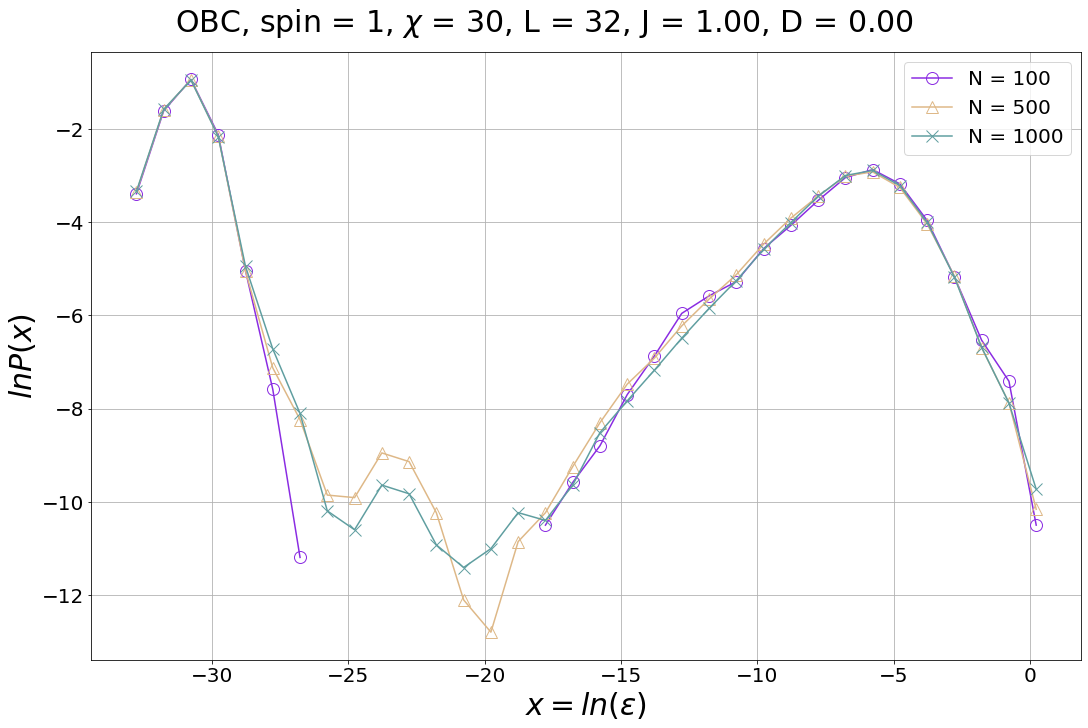

In [38]:
## energy gap distribution

OrderPara = "Energy_gap"
Ls = [32]
Dimer = ["Dim000"]
Jdis = ["Jdis100"]
Ns = [100, 500, 1000]

width = float(1)
fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(15,10))

for d in range(len(Dimer)):
    dimer = Dimer[d]
    D = float(Dimer[d][3] + '.' + Dimer[d][4] + Dimer[d][5])

    for j in range(len(Jdis)):
        jdis = Jdis[j]
        J = float(Jdis[j][4] + '.' + Jdis[j][5] + Jdis[j][6])

        for l in range(len(Ls)):
            L = Ls[l]

            for n in range(len(Ns)):
                N = Ns[n]

                myfile = my_metadata_file + OrderPara +"/"+ jdis +"/"+ dimer +"/OBC_L"+ str(L) +"_P"+ str(P) +"_m"+ str(M) +"_Gap_"+ str(N) +".csv"
                if (os.path.exists(myfile) == False): # Some data is not ok, so we need to ignore it.
                    print(myfile + ' does not exist!!!')
                    continue

                df = pd.read_csv(myfile)

                hist, bin_edges = np.histogram(df['energy'], bins=np.arange(min(df['energy']), max(df['energy']) + width, width), density=False)
                bin_mids = []
                for b in np.arange(0, len(bin_edges)-1, 1):
                    bin_mids.append((bin_edges[b+1] + bin_edges[b])/2)

                hist2 = hist / hist.sum() # normalization
                data2 = {'x': bin_mids, 'Pdis': hist2}
                output2 = pd.DataFrame(data2)
                output2.loc[output2['Pdis'] != 0, 'Pdis'] = np.log(output2.loc[output2['Pdis'] != 0, 'Pdis'])
                output2.loc[output2['Pdis'] == 0, 'Pdis'] = np.nan   # discontinue

                ax.plot(output2['x'], output2['Pdis'], marr[n], color = carr[n+l], markersize=12, markerfacecolor='None', label= 'N = %d' %(N))

ax.legend(loc = 'best',fontsize=20)
ax.set_xlabel('$x=ln(\epsilon)$', fontsize=30)
ax.set_ylabel(r'$lnP(x)$', fontsize=30)
# ax.set_xlim([-20, 0])
# ax.set_ylim([0, 0.08])
ax.grid(which='major', linestyle='-')
ax.tick_params(labelsize=20) 
fig.suptitle('OBC, spin = 1, $\chi$ = 30, L = %d, J = %.2f, D = %.2f' %(L, J, D), fontsize=30)

plt.show()

### 固定 D、N、L，看 J

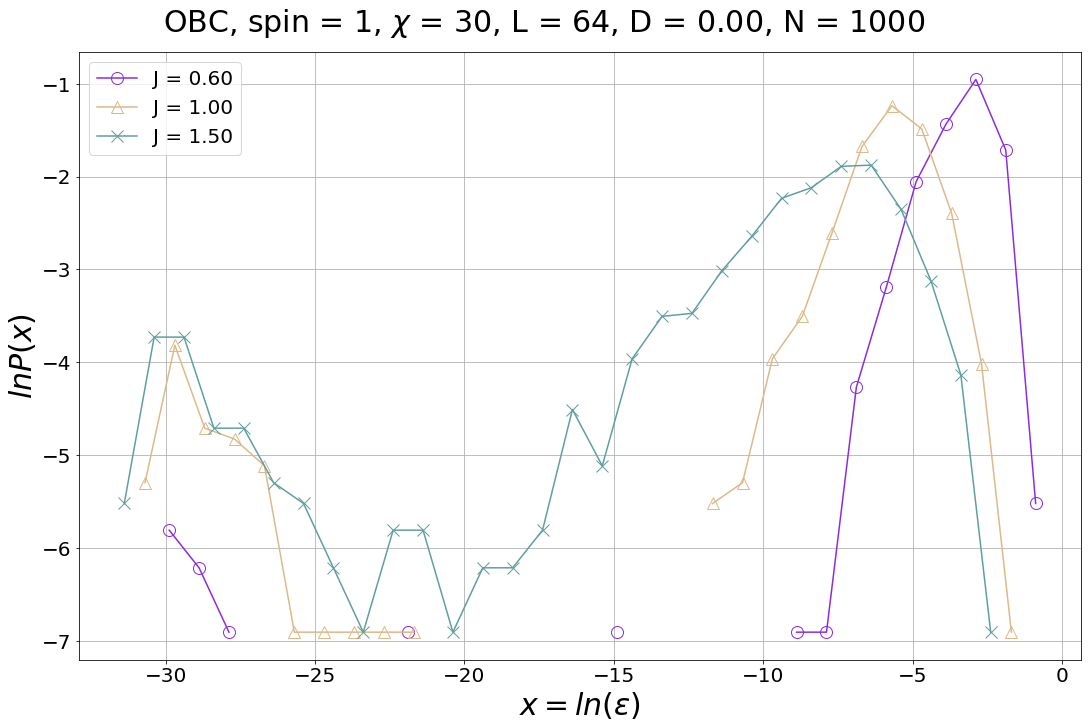

In [18]:
## energy gap distribution

OrderPara = "Energy_gap"
Ls = [64]
Dimer = ["Dim000"]
Jdis = ["Jdis060","Jdis100","Jdis150"]
width = float(1)
Ns = [1000]

fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(15,10))

for d in range(len(Dimer)):
    dimer = Dimer[d]
    D = float(Dimer[d][3] + '.' + Dimer[d][4] + Dimer[d][5])

    for j in range(len(Jdis)):
        jdis = Jdis[j]
        J = float(Jdis[j][4] + '.' + Jdis[j][5] + Jdis[j][6])

        for l in range(len(Ls)):
            L = Ls[l]

            for n in range(len(Ns)):
                N = Ns[n]

                myfile = my_metadata_file + OrderPara +"/"+ jdis +"/"+ dimer +"/PBC_L"+ str(L) +"_P"+ str(P) +"_m"+ str(M) +"_Gap_"+ str(N) +".csv"
                if (os.path.exists(myfile) == False): # Some data is not ok, so we need to ignore it.
                    print(myfile + ' does not exist!!!')
                    continue

                df = pd.read_csv(myfile)
                # print(df)
                # print(min(df))
                # print(max(df))
                # print(np.arange(min(df), max(df) + width, width))

                hist, bin_edges = np.histogram(df['energy'], bins=np.arange(min(df['energy']), max(df['energy']) + width, width), density=False)
                bin_mids = []
                for b in np.arange(0, len(bin_edges)-1, 1):
                    bin_mids.append((bin_edges[b+1] + bin_edges[b])/2)
                # print(hist.sum())

                hist2 = hist / hist.sum() # normalization
                data2 = {'x': bin_mids, 'Pdis': hist2}
                output2 = pd.DataFrame(data2)
                output2.loc[output2['Pdis'] != 0, 'Pdis'] = np.log(output2.loc[output2['Pdis'] != 0, 'Pdis'])
                output2.loc[output2['Pdis'] == 0, 'Pdis'] = np.nan   # discontinue

                ax.plot(output2['x'], output2['Pdis'], marr[j], color = carr[n+j], markersize=12, markerfacecolor='None', label= 'J = %.2f' %(J))

ax.legend(loc = 'best',fontsize=20)
ax.set_xlabel('$x=ln(\epsilon)$', fontsize=30)
ax.set_ylabel(r'$lnP(x)$', fontsize=30)
# ax.set_xlim([-20, 0])
# ax.set_ylim([0, 0.08])
ax.grid(which='major', linestyle='-')
ax.tick_params(labelsize=20) 
fig.suptitle('OBC, spin = 1, $\chi$ = 30, L = %d, D = %.2f, N = %d' %(L, D, N), fontsize=30)

plt.show()

### 固定 D、N、J，看 L

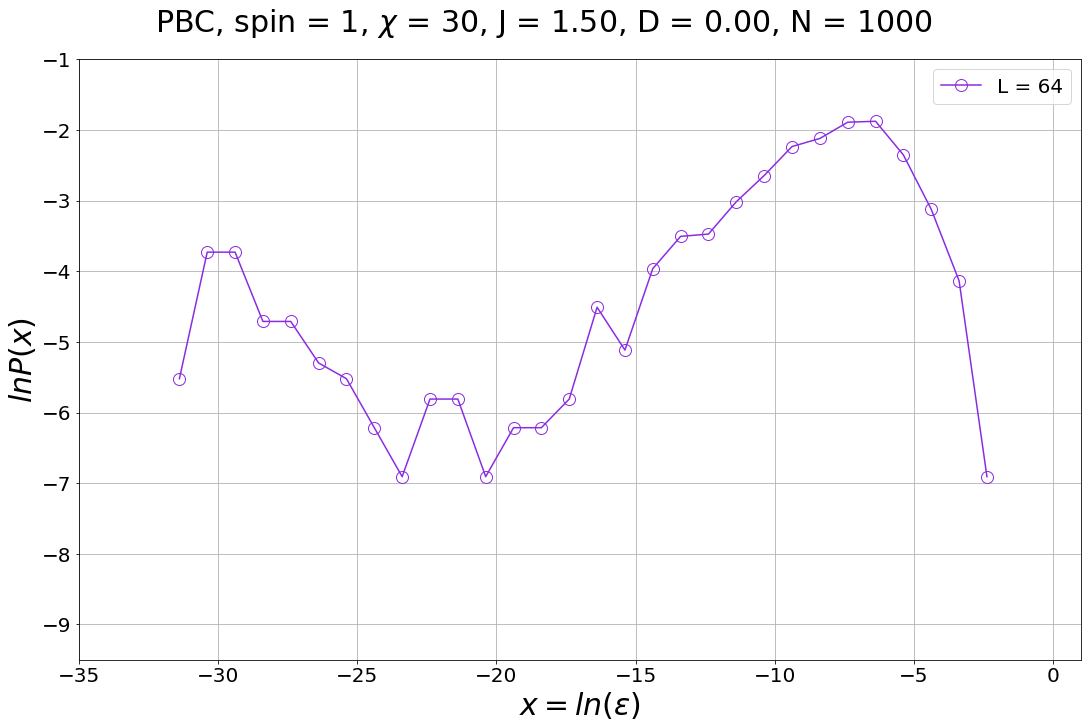

In [19]:
## energy gap distribution
bc = "PBC"
OrderPara = "Energy_gap"
Ls = [64]
Dimer = ["Dim000"]
Jdis = ["Jdis150"]
width = float(1)
Ns = [1000]

fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(15,10))

for d in range(len(Dimer)):
    dimer = Dimer[d]
    D = float(Dimer[d][3] + '.' + Dimer[d][4] + Dimer[d][5])

    for j in range(len(Jdis)):
        jdis = Jdis[j]
        J = float(Jdis[j][4] + '.' + Jdis[j][5] + Jdis[j][6])

        for l in range(len(Ls)):
            L = Ls[l]

            for n in range(len(Ns)):
                N = Ns[n]

                myfile = my_metadata_file + OrderPara +"/"+ jdis +"/"+ dimer +"/"+ bc +"_L"+ str(L) +"_P"+ str(P) +"_m"+ str(M) +"_Gap_"+ str(N) +".csv"
                if (os.path.exists(myfile) == False): # Some data is not ok, so we need to ignore it.
                    print(myfile + ' does not exist!!!')
                    continue

                df = pd.read_csv(myfile)
                # print(df)
                # print(min(df))
                # print(max(df))
                # print(np.arange(min(df), max(df) + width, width))

                hist, bin_edges = np.histogram(df['energy'], bins=np.arange(min(df['energy']), max(df['energy']) + width, width), density=False)
                bin_mids = []
                for b in np.arange(0, len(bin_edges)-1, 1):
                    bin_mids.append((bin_edges[b+1] + bin_edges[b])/2)
                # print(hist.sum())

                hist2 = hist / hist.sum() # normalization
                data2 = {'x': bin_mids, 'Pdis': hist2}
                output2 = pd.DataFrame(data2)
                output2.loc[output2['Pdis'] != 0, 'Pdis'] = np.log(output2.loc[output2['Pdis'] != 0, 'Pdis'])
                output2.loc[output2['Pdis'] == 0, 'Pdis'] = np.nan   # discontinue

                ax.plot(output2['x'], output2['Pdis'], marr[l], color = carr[n+l], markersize=12, markerfacecolor='None', label= 'L = %d' %(L))

ax.legend(loc = 'best',fontsize=20)
ax.set_xlabel('$x=ln(\epsilon)$', fontsize=30)
ax.set_ylabel(r'$lnP(x)$', fontsize=30)
ax.set_xlim([-35, 1])
ax.set_ylim([-9.5, -1])
ax.grid(which='major', linestyle='-')
ax.tick_params(labelsize=20) 
fig.suptitle(bc + ', spin = 1, $\chi$ = 30, J = %.2f, D = %.2f, N = %d' %(J, D, N), fontsize=30)

plt.show()

###  scaling collapse $ln(\epsilon) L^{-\Psi}$

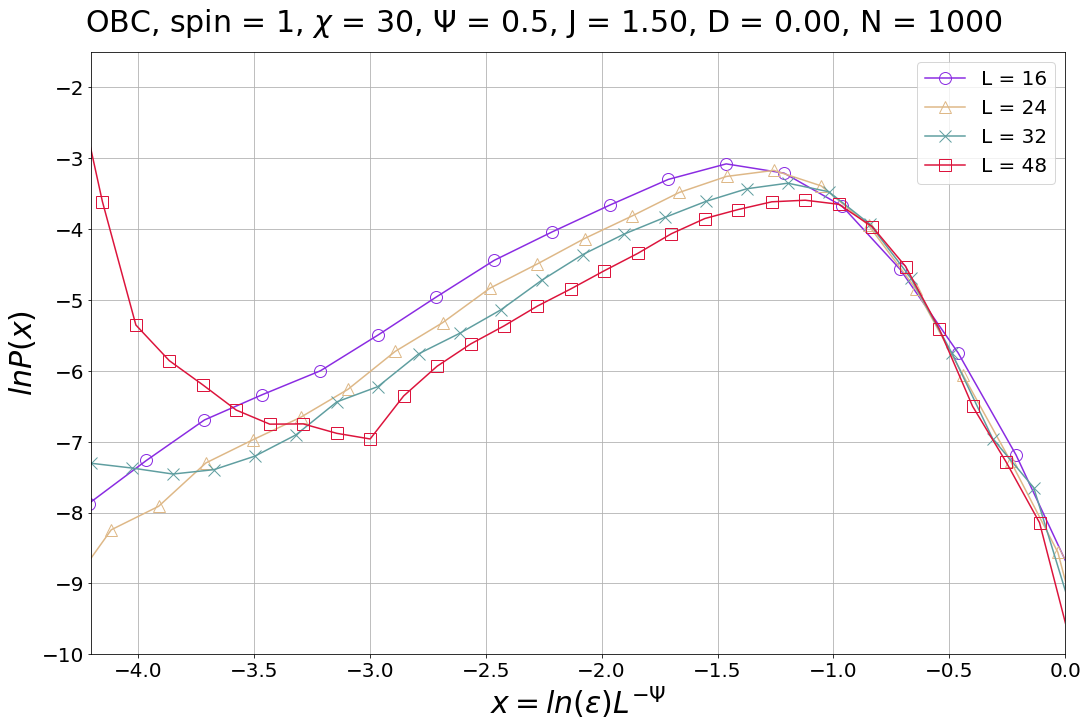

In [50]:
## energy gap distribution

OrderPara = "Energy_gap"
Ls = [16,24,32,48]
Dimer = ["Dim000"]
# Dimer = ["Dim000","Dim005","Dim010","Dim015","Dim020","Dim030","Dim040","Dim050","Dim055","Dim060","Dim065"]
Jdis = ["Jdis150"]
width = float(1)
Ns = [1000]

fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(15,10))

for d in range(len(Dimer)):
    dimer = Dimer[d]
    D = float(Dimer[d][3] + '.' + Dimer[d][4] + Dimer[d][5])

    for j in range(len(Jdis)):
        jdis = Jdis[j]
        J = float(Jdis[j][4] + '.' + Jdis[j][5] + Jdis[j][6])
        if (J == 1):
            psi = 1/3
        elif (J == 1.5):
            psi = 1/2
        else:
            psi = 0

        for l in range(len(Ls)):
            L = Ls[l]

            for n in range(len(Ns)):
                N = Ns[n]

                myfile = my_metadata_file + OrderPara +"/"+ jdis +"/"+ dimer +"/OBC_L"+ str(L) +"_P"+ str(P) +"_m"+ str(M) +"_Gap_"+ str(N) +".csv"
                if (os.path.exists(myfile) == False): # Some data is not ok, so we need to ignore it.
                    print(myfile + ' does not exist!!!')
                    continue

                df = pd.read_csv(myfile)
                # print(df)
                # print(min(df))
                # print(max(df))
                # print(np.arange(min(df), max(df) + width, width))

                hist, bin_edges = np.histogram(df['energy'], bins=np.arange(min(df['energy']), max(df['energy']) + width, width), density=False)
                bin_mids = []
                for b in np.arange(0, len(bin_edges)-1, 1):
                    bin_mids.append((bin_edges[b+1] + bin_edges[b])/2)
                # print(hist.sum())

                hist2 = hist / hist.sum() # normalization
                data2 = {'x': bin_mids, 'Pdis': hist2}
                output2 = pd.DataFrame(data2)
                output2.loc[output2['Pdis'] != 0, 'Pdis'] = np.log(output2.loc[output2['Pdis'] != 0, 'Pdis'])
                output2.loc[output2['Pdis'] == 0, 'Pdis'] = np.nan   # discontinue

                ax.plot(output2['x']*L**-psi, output2['Pdis'], marr[l], color = carr[n+l], markersize=12, markerfacecolor='None', label= 'L = %d' %(L))

ax.legend(loc = 'best',fontsize=20)
ax.set_xlabel('$x=ln(\epsilon)L^{-\Psi}$', fontsize=30)
ax.set_ylabel(r'$lnP(x)$', fontsize=30)
ax.set_xlim([-4.2, 0])
ax.set_ylim([-10, -1.5])
ax.grid(which='major', linestyle='-')
ax.tick_params(labelsize=20) 
fig.suptitle('OBC, spin = 1, $\chi$ = 30, $\Psi$ = %.1f, J = %.2f, D = %.2f, N = %d' %(psi, J, D, N), fontsize=30)

plt.show()

## End to end correlation distribution

### 固定 D、J、L，看 N

100 -0.3405944939102744 4.1728722601959065
500 -0.3405944939102744 5.967814689924598
1000 -0.37979355578681695 5.967814689924598


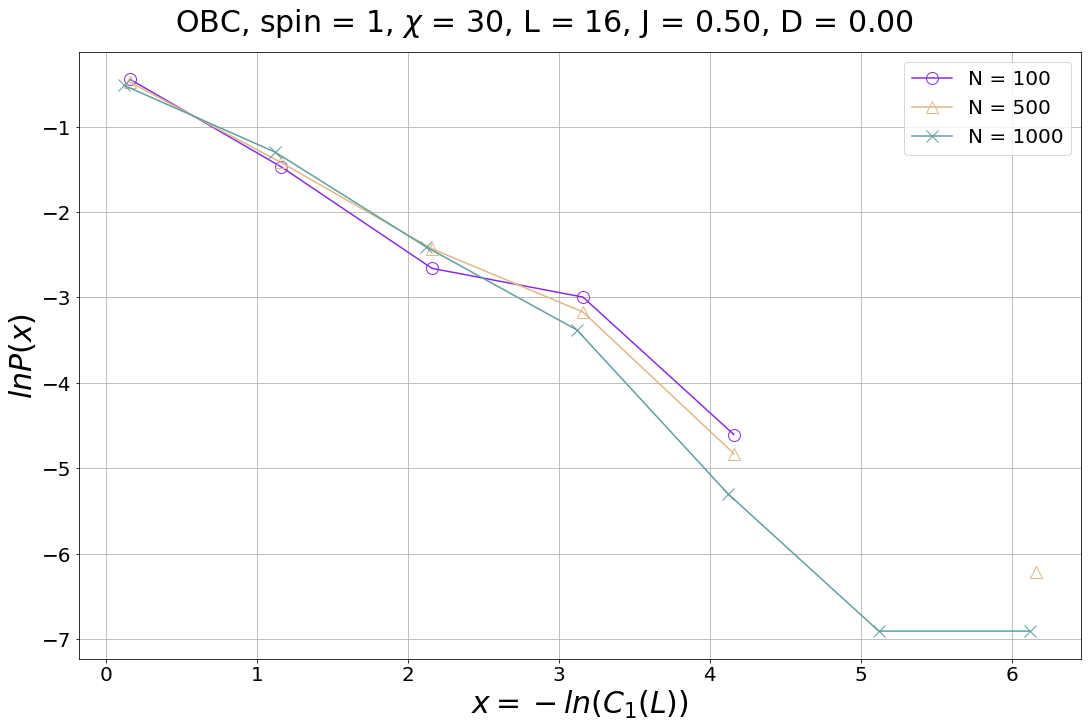

In [42]:
## end to end correlation gap distribution

OrderPara = "Etoe_distri"
Ls = [16]
Dimer = ["Dim000"]
Jdis = ["Jdis050"]
Ns = [100, 500, 1000]
width = float(1)

fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(15,10))

for d in range(len(Dimer)):
    dimer = Dimer[d]
    D = float(Dimer[d][3] + '.' + Dimer[d][4] + Dimer[d][5])

    for j in range(len(Jdis)):
        jdis = Jdis[j]
        J = float(Jdis[j][4] + '.' + Jdis[j][5] + Jdis[j][6])

        for l in range(len(Ls)):
            L = Ls[l]

            for n in range(len(Ns)):
                N = Ns[n]

                myfile = my_metadata_file + OrderPara +"/"+ jdis +"/"+ dimer +"/OBC_L"+ str(L) +"_P"+ str(P) +"_m"+ str(M) +"_Corr_"+ str(N) +".csv"
                if (os.path.exists(myfile) == False): # Some data is not ok, so we need to ignore it.
                    print(myfile + ' does not exist!!!')
                    continue

                df = pd.read_csv(myfile)

                hist, bin_edges = np.histogram(df['corr'], bins=np.arange(min(df['corr']), max(df['corr']) + width, width), density=False)
                bin_mids = []
                for b in np.arange(0, len(bin_edges)-1, 1):
                    bin_mids.append((bin_edges[b+1] + bin_edges[b])/2)
                print(hist.sum(), min(df['corr']), max(df['corr']))
                
                hist2 = hist / hist.sum() # normalization
                data2 = {'x': bin_mids, 'Pdis': hist2}
                output2 = pd.DataFrame(data2)
                output2.loc[output2['Pdis'] != 0, 'Pdis'] = np.log(output2.loc[output2['Pdis'] != 0, 'Pdis'])
                output2.loc[output2['Pdis'] == 0, 'Pdis'] = np.nan   # discontinue

                ax.plot(output2['x'], output2['Pdis'], marr[n], color = carr[n+l], markersize=12, markerfacecolor='None', label= 'N = %d' %(N))

ax.legend(loc = 'best',fontsize=20)
ax.set_xlabel('$x=-ln(C_1(L))$', fontsize=30)
ax.set_ylabel(r'$lnP(x)$', fontsize=30)
# ax.set_xlim([-20, 0])
# ax.set_ylim([0, 0.08])
ax.grid(which='major', linestyle='-')
ax.tick_params(labelsize=20) 
fig.suptitle('OBC, spin = 1, $\chi$ = 30, L = %d, J = %.2f, D = %.2f' %(L, J, D), fontsize=30)

plt.show()

### 固定 D、N、L，看 J

974 -0.2746636137484016 6.180463349678552
991 -0.6062212559554091 16.01705186598069
981 -0.6716235145961111 26.03310351782744


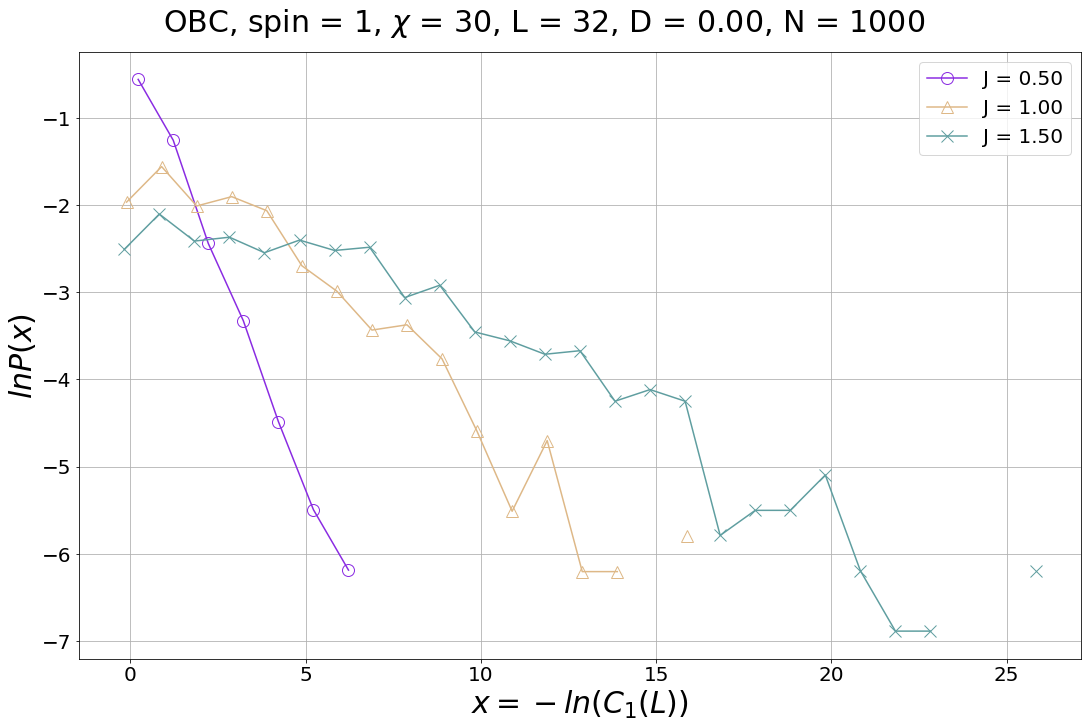

In [43]:
## energy gap distribution

OrderPara = "Etoe_distri"
Ls = [32]
Dimer = ["Dim000"]
Jdis = ["Jdis050","Jdis100","Jdis150"]
width = float(1)
Ns = [1000]

fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(15,10))

for d in range(len(Dimer)):
    dimer = Dimer[d]
    D = float(Dimer[d][3] + '.' + Dimer[d][4] + Dimer[d][5])

    for j in range(len(Jdis)):
        jdis = Jdis[j]
        J = float(Jdis[j][4] + '.' + Jdis[j][5] + Jdis[j][6])

        for l in range(len(Ls)):
            L = Ls[l]

            for n in range(len(Ns)):
                N = Ns[n]

                myfile = my_metadata_file + OrderPara +"/"+ jdis +"/"+ dimer +"/OBC_L"+ str(L) +"_P"+ str(P) +"_m"+ str(M) +"_Corr_"+ str(N) +".csv"
                if (os.path.exists(myfile) == False): # Some data is not ok, so we need to ignore it.
                    print(myfile + ' does not exist!!!')
                    continue

                df = pd.read_csv(myfile)
                # print(df)
                # print(min(df))
                # print(max(df))
                # print(np.arange(min(df), max(df) + width, width))

                hist, bin_edges = np.histogram(df['corr'], bins=np.arange(min(df['corr']), max(df['corr']) + width, width), density=False)
                bin_mids = []
                for b in np.arange(0, len(bin_edges)-1, 1):
                    bin_mids.append((bin_edges[b+1] + bin_edges[b])/2)
                print(hist.sum(), min(df['corr']), max(df['corr']))
                
                hist2 = hist / hist.sum() # normalization
                data2 = {'x': bin_mids, 'Pdis': hist2}
                output2 = pd.DataFrame(data2)
                output2.loc[output2['Pdis'] != 0, 'Pdis'] = np.log(output2.loc[output2['Pdis'] != 0, 'Pdis'])
                output2.loc[output2['Pdis'] == 0, 'Pdis'] = np.nan   # discontinue

                ax.plot(output2['x'], output2['Pdis'], marr[j], color = carr[n+j], markersize=12, markerfacecolor='None', label= 'J = %.2f' %(J))

ax.legend(loc = 'best',fontsize=20)
ax.set_xlabel('$x=-ln(C_1(L))$', fontsize=30)
ax.set_ylabel(r'$lnP(x)$', fontsize=30)
# ax.set_xlim([-20, 0])
# ax.set_ylim([0, 0.08])
ax.grid(which='major', linestyle='-')
ax.tick_params(labelsize=20) 
fig.suptitle('OBC, spin = 1, $\chi$ = 30, L = %d, D = %.2f, N = %d' %(L, D, N), fontsize=30)

plt.show()

### 固定 D、N、J，看 L

997 -0.6857601574354149 13.291422461188095
989 -0.5633883744820133 14.026661164718274
991 -0.6062212559554091 16.01705186598069
989 -0.3898871033434864 20.260844605856505


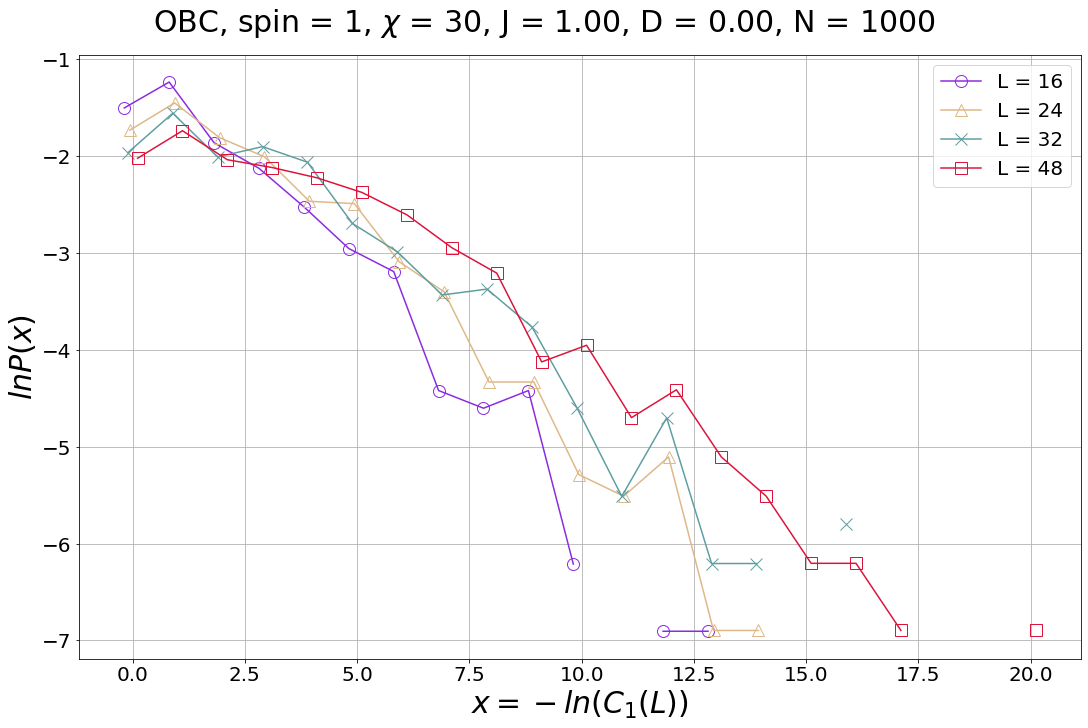

In [44]:
## energy gap distribution

OrderPara = "Etoe_distri"
Ls = [16,24,32,48]
Dimer = ["Dim000"]
Jdis = ["Jdis100"]
width = float(1)
Ns = [1000]

fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(15,10))

for d in range(len(Dimer)):
    dimer = Dimer[d]
    D = float(Dimer[d][3] + '.' + Dimer[d][4] + Dimer[d][5])

    for j in range(len(Jdis)):
        jdis = Jdis[j]
        J = float(Jdis[j][4] + '.' + Jdis[j][5] + Jdis[j][6])

        for l in range(len(Ls)):
            L = Ls[l]

            for n in range(len(Ns)):
                N = Ns[n]

                myfile = my_metadata_file + OrderPara +"/"+ jdis +"/"+ dimer +"/OBC_L"+ str(L) +"_P"+ str(P) +"_m"+ str(M) +"_Corr_"+ str(N) +".csv"
                if (os.path.exists(myfile) == False): # Some data is not ok, so we need to ignore it.
                    print(myfile + ' does not exist!!!')
                    continue

                df = pd.read_csv(myfile)
                # print(df)
                # print(min(df))
                # print(max(df))
                # print(np.arange(min(df), max(df) + width, width))

                hist, bin_edges = np.histogram(df['corr'], bins=np.arange(min(df['corr']), max(df['corr']) + width, width), density=False)
                bin_mids = []
                for b in np.arange(0, len(bin_edges)-1, 1):
                    bin_mids.append((bin_edges[b+1] + bin_edges[b])/2)

                print(hist.sum(), min(df['corr']), max(df['corr']))

                hist2 = hist / hist.sum() # normalization
                data2 = {'x': bin_mids, 'Pdis': hist2}
                output2 = pd.DataFrame(data2)
                output2.loc[output2['Pdis'] != 0, 'Pdis'] = np.log(output2.loc[output2['Pdis'] != 0, 'Pdis'])
                output2.loc[output2['Pdis'] == 0, 'Pdis'] = np.nan   # discontinue

                ax.plot(output2['x'], output2['Pdis'], marr[l], color = carr[n+l], markersize=12, markerfacecolor='None', label= 'L = %d' %(L))

ax.legend(loc = 'best',fontsize=20)
ax.set_xlabel('$x=-ln(C_1(L))$', fontsize=30)
ax.set_ylabel(r'$lnP(x)$', fontsize=30)
# ax.set_xlim([-20, 0])
# ax.set_ylim([0, 0.08])
ax.grid(which='major', linestyle='-')
ax.tick_params(labelsize=20) 
fig.suptitle('OBC, spin = 1, $\chi$ = 30, J = %.2f, D = %.2f, N = %d' %(J, D, N), fontsize=30)

plt.show()

## End to end correlation $C_1(L)$ v.s.  **<font color = red>L</font>**

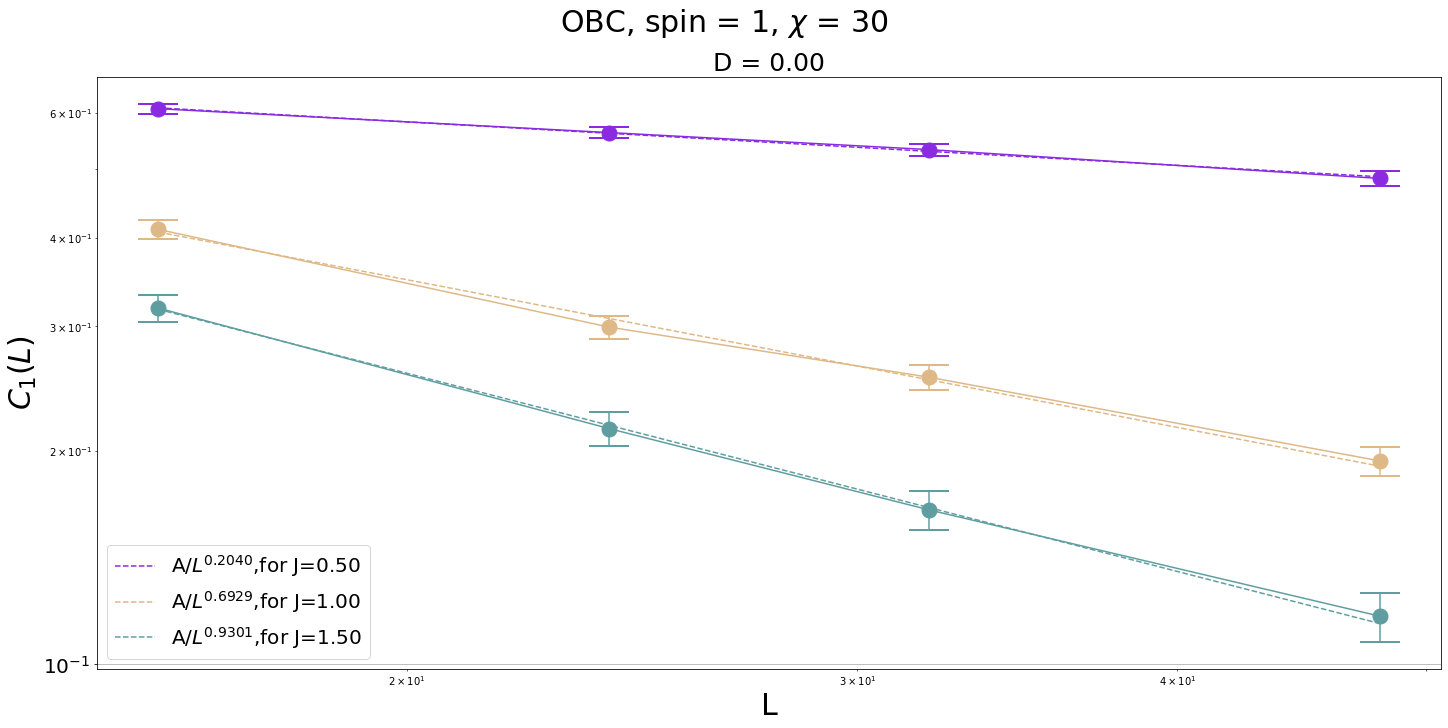

In [45]:
def func(x, a, b):
    return a/(x**b)

OrderPara = "EndtoEnd"
Ls = [16,24,32,48]
Dimer = ["Dim000"]
# Jdis = ["Jdis020","Jdis040","Jdis060","Jdis070","Jdis080","Jdis090","Jdis100"]
Jdis = ["Jdis050","Jdis100","Jdis150"]

fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(20,10))

for d in range(len(Dimer)):
    dimer = Dimer[d]
    D = float(Dimer[d][3] + '.' + Dimer[d][4] + Dimer[d][5])

    for j in range(len(Jdis)):
        jdis = Jdis[j]
        J = float(Jdis[j][4] + '.' + Jdis[j][5] + Jdis[j][6])
        dfplt = pd.DataFrame(columns = ['L', 'corr', 'error'], dtype=float)  

        for l in range(len(Ls)):
            L = Ls[l]
             
            myfile = my_metadata_file + OrderPara +'/'+ jdis +'/'+ dimer +'/OBC_L'+ str(L) +'_P'+ str(P) +'_m'+ str(M) +'_Corr.csv'
            if (os.path.exists(myfile) == False): # Some data is not ok, so we need to ignore it.
                # print(dimer + ' does not exist!!!')
                continue
            
            df = pd.read_csv(myfile)
            mean = {'L':L, 'corr':df['corr'][0], 'error':df['error'][0]}
            dfplt.loc[l] = mean

        if (dfplt.empty):
            continue

        popt, pcov = curve_fit(func, dfplt['L'], dfplt['corr'])
        a = popt[0] 
        b = popt[1]
        yvals = func(dfplt['L'],a,b)
        ax.plot(dfplt['L'], yvals, '--', color=carr[j], markersize = 15, label = 'A/$L^{%.4f}$,for J=%.2f' %(b, J))
        ax.plot(dfplt['L'], dfplt['corr'], marr[int(j/7)], color=carr[j], markersize = 15)
        ax.errorbar(dfplt['L'], dfplt['corr'], yerr=dfplt['error'], linestyle='None', capsize=20, capthick=2, color=carr[j], label=None)
        ax.set_xlabel('L', fontsize=30)
        ax.set_ylabel(r'$C_{1}(L)$', fontsize=30)
        ax.set_title(r"D = %.2f" %(D), fontsize=25)
        # ax.set_xlim([0,65])
        # ax.set_ylim([0, 4])
        ax.legend(loc = 'best',fontsize=20)

ax.set_xscale('log')
ax.set_yscale('log')  
ax.grid(which='major', linestyle='-')
ax.tick_params(labelsize=20) 
fig.suptitle('OBC, spin = %s, $\chi$ = %d' % (spin, M), fontsize=30)
# plt.savefig('L'+ str(L) +'_Spin'+ str(spin) +'_' + BC + '_P'+ str(P) +'_m'+ str(M) +'_Oz-D.pdf', format='pdf', dpi=4000)
plt.show() 

In [15]:
Energy_gaps = pd.DataFrame(columns = ['energy'])
N = 2
for i in range(N):
    myfile = './energy'+ str(i+1) +'.csv'
    df = pd.read_csv(myfile)
    print(df)
    E0 = df['energy'][0]
    E1 = df['energy'][1]
    print(E0, E1)
    sample = {'energy':abs(E1-E0)}
    Energy_gaps.loc[i] = sample

Energy_gaps = Energy_gaps[Energy_gaps['energy'] != 0]
Energy_gaps['energy'] = np.log(Energy_gaps['energy'])
print(Energy_gaps)

        energy
0   -12.605610
1   -12.592857
2   -12.592857
3   -12.592857
4   -12.549548
..         ...
751  -6.976535
752  -6.976535
753  -6.976535
754  -6.976535
755  -6.976535

[756 rows x 1 columns]
-12.60561029374939 -12.592856705155329
        energy
0   -12.004698
1   -11.937304
2   -11.937304
3   -11.937304
4   -11.878347
..         ...
779  -9.793824
780  -9.787787
781  -9.772579
782  -9.772579
783  -9.772579

[784 rows x 1 columns]
-12.004698449259429 -11.937304321886922
     energy
0 -4.361943
1 -2.697197
